# Evolutionary Computation Assignment 1

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [1]:
from utils import TspInstance
import math
import numpy as np
import pandas as pd

tsp_a = TspInstance("TSPA.csv")
tsp_b = TspInstance("TSPB.csv")

## Problem Instance Comparison


In [2]:
print("Average cost for an instance A:", np.mean(tsp_a.node_costs))
print("Average cost for an instance B:", np.mean(tsp_b.node_costs))

Average cost for an instance A: 978.165
Average cost for an instance B: 494.58


## Random Solution

Randomly select half of the nodes and shuffle them.


In [3]:
def random_solution(tsp: TspInstance):
    num_nodes = tsp.distance_matrix.shape[0]
    num_nodes_to_select = math.ceil(num_nodes / 2)
    selected_nodes = np.random.choice(num_nodes, num_nodes_to_select, replace=False)
    return selected_nodes

## Nearest Neighbor End

1. Start the _acyclic path_ with a random node.
2. While selected less than half of all nodes:
   1. Add a node that will increase the cost of the _acyclic path_ the least if added to the _end of the path_.

The cost is defined as the _sum of each node's cost and the distances between nodes_.


In [4]:
def nearest_neighbor_end(tsp: TspInstance):
    solution = [np.random.choice(tsp.size)]

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            cost = tsp.get_cost(solution + [node_index])
            if min_cost is None or cost < min_cost:
                selected_node_index = node_index
                min_cost = cost

        solution.append(selected_node_index)

    return solution

## Nearest Neighbor Any

1. Start the _acyclic path_ with a random node.
2. While selected less than half of all nodes:
   1. Add a node that will increase the cost of the _acyclic path_ the least if added _anywhere in the path_.

The cost is defined as the _sum of each node's cost and the distances between nodes_.


In [5]:
def nearest_neighbor_any(tsp: TspInstance):
    solution = [np.random.choice(tsp.size)]

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = selected_path_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for path_index in range(len(solution) + 1):
                test_solution = list(solution)
                test_solution.insert(path_index, node_index)
                
                prev_node = solution[path_index - 1]
                next_node = solution[path_index % len(solution)]

                cost = (
                    tsp.distance_matrix[prev_node][node_index] +
                    tsp.distance_matrix[node_index][next_node] -
                    tsp.distance_matrix[prev_node][next_node] +
                    tsp.node_costs[node_index]
                )
                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    selected_path_index = path_index
                    min_cost = cost

        solution.insert(selected_path_index, selected_node_index)

    return solution

## Greedy cycle

1. Initialize the _cycle_ with a _random node_ and _another node closest to it_.
2. While selected less than half of all nodes:
   1. Test the _difference in cycle cost_ introduced by inserting a node at _any possible place_.
   2. Insert the node minimazing the cost at the respective place.

The cost difference is defined as follows: _inserted_node_cost_ + _cost_of_added_connections_ - _cost_of_removed_connection_.


In [6]:
def greedy_cycle(tsp: TspInstance):
    solution = [np.random.choice(tsp.size)]
    solution.append(np.argmin(tsp.distance_matrix[solution[0]]))

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = selected_path_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for path_index in range(len(solution) + 1):
                test_solution = list(solution)
                test_solution.insert(path_index, node_index)
                
                prev_node = solution[path_index - 1]
                next_node = solution[path_index % len(solution)]

                # Calculate the just cost of inserting the node at the current position
                cost = (
                    tsp.distance_matrix[prev_node][node_index] +
                    tsp.node_costs[node_index]
                )
                
                # If the node is not being inserted at the end of the solution, add the cost of the edge to the next node and 
                # subtract the cost of the edge from the previous node
                if next_node != solution[0]:
                    cost += (
                        tsp.distance_matrix[node_index][next_node] -
                        tsp.distance_matrix[prev_node][next_node]
                    )
                
                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    selected_path_index = path_index
                    min_cost = cost

        solution.insert(selected_path_index, selected_node_index)

    return solution

## Experiments


In [7]:
num_iter = 200

experiments = (
    tsp_a.run_experiments(random_solution, num_iterations=num_iter),
    tsp_b.run_experiments(random_solution, num_iterations=num_iter),
    tsp_a.run_experiments(nearest_neighbor_end, num_iterations=num_iter),
    tsp_b.run_experiments(nearest_neighbor_end, num_iterations=num_iter),
    tsp_a.run_experiments(nearest_neighbor_any, num_iterations=num_iter),
    tsp_b.run_experiments(nearest_neighbor_any, num_iterations=num_iter),
    tsp_a.run_experiments(greedy_cycle, True, num_iterations=num_iter),
    tsp_b.run_experiments(greedy_cycle, True, num_iterations=num_iter),
)

Running experiment with solution getter: random_solution
Time elapsed: 00:00
Running experiment with solution getter: random_solution
Time elapsed: 00:00
Running experiment with solution getter: nearest_neighbor_end
Time elapsed: 00:31
Running experiment with solution getter: nearest_neighbor_end
Time elapsed: 00:32
Running experiment with solution getter: nearest_neighbor_any
Time elapsed: 01:21
Running experiment with solution getter: nearest_neighbor_any
Time elapsed: 01:22
Running experiment with solution getter: greedy_cycle
Time elapsed: 01:24
Running experiment with solution getter: greedy_cycle
Time elapsed: 01:23


In [14]:
columns = (
    "Random A",
    "Random B",
    "NN-End A",
    "NN-End B",
    "NN-Any A",
    "NN-Any B",
    "Cycle A",
    "Cycle B",
)

all = pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=("min", "max", "avg"),
)

display(all)

df_a = pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=("min", "max", "avg"),
).filter(regex="A$", axis=1)

df_b = pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=("min", "max", "avg"),
).filter(regex="B$", axis=1)

display(df_a)
display(df_b)

,Random A,Random B,NN-End A,NN-End B,NN-Any A,NN-Any B,Cycle A,Cycle B
min,235530.0,187468.00,76880.00,47940.00,71255.000,48973.00,70785.000,49038.000
max,294275.0,239215.00,105198.00,67185.00,74220.000,57348.00,76026.000,57456.000
avg,264836.7,213266.78,83680.24,52485.63,72661.445,51390.06,73030.805,51660.935


,Random A,NN-End A,NN-Any A,Cycle A
min,235530.0,76880.00,71255.000,70785.000
max,294275.0,105198.00,74220.000,76026.000
avg,264836.7,83680.24,72661.445,73030.805


,Random B,NN-End B,NN-Any B,Cycle B
min,187468.00,47940.00,48973.00,49038.000
max,239215.00,67185.00,57348.00,57456.000
avg,213266.78,52485.63,51390.06,51660.935


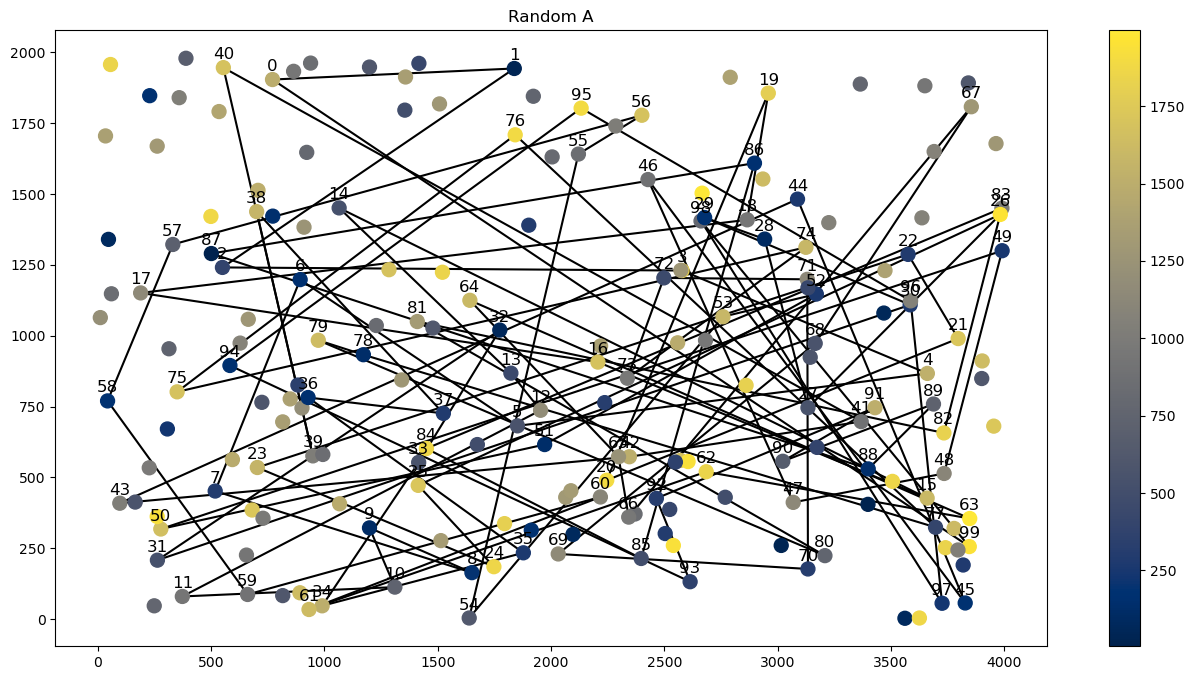

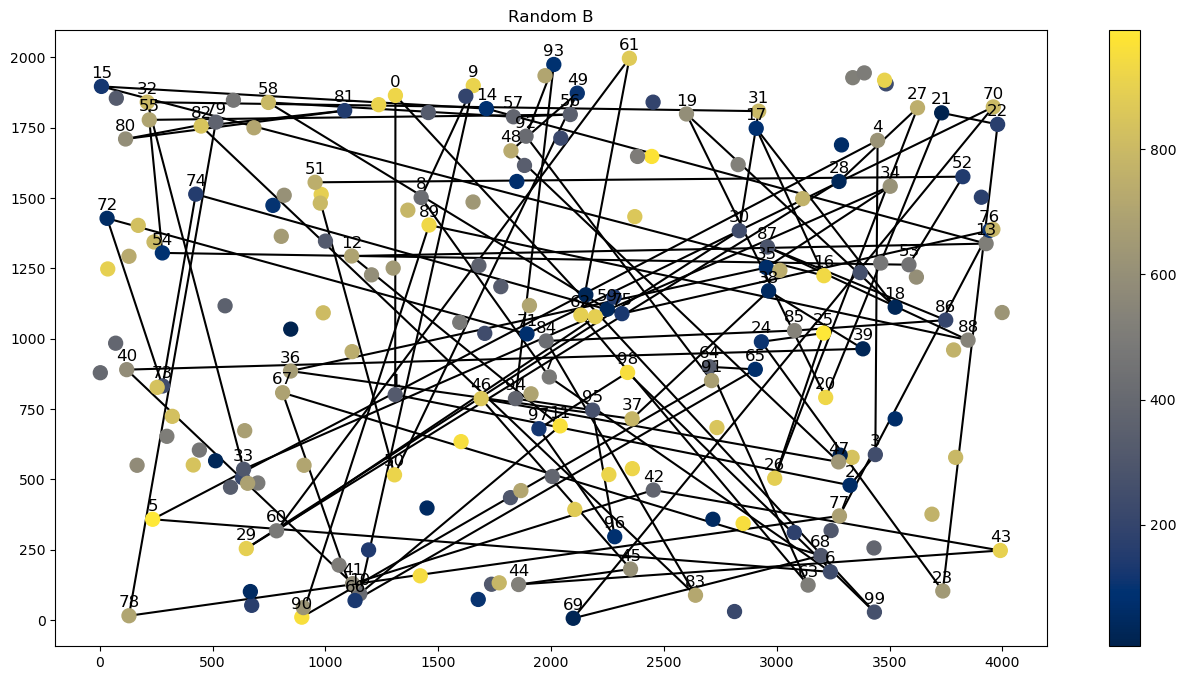

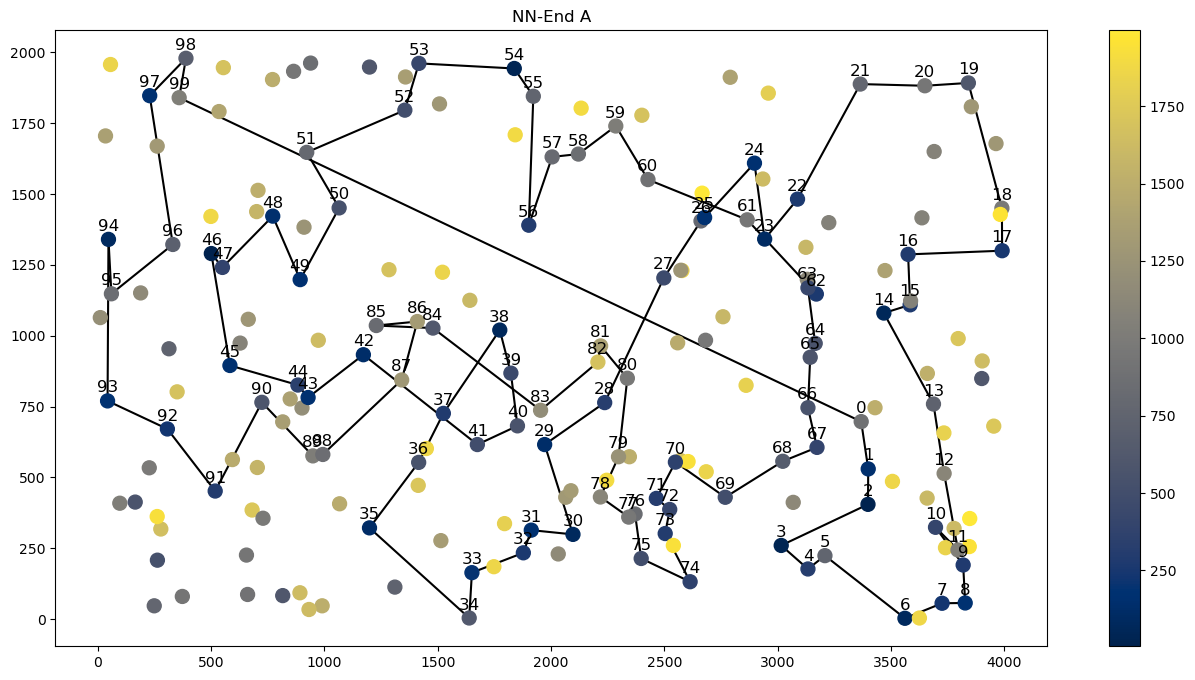

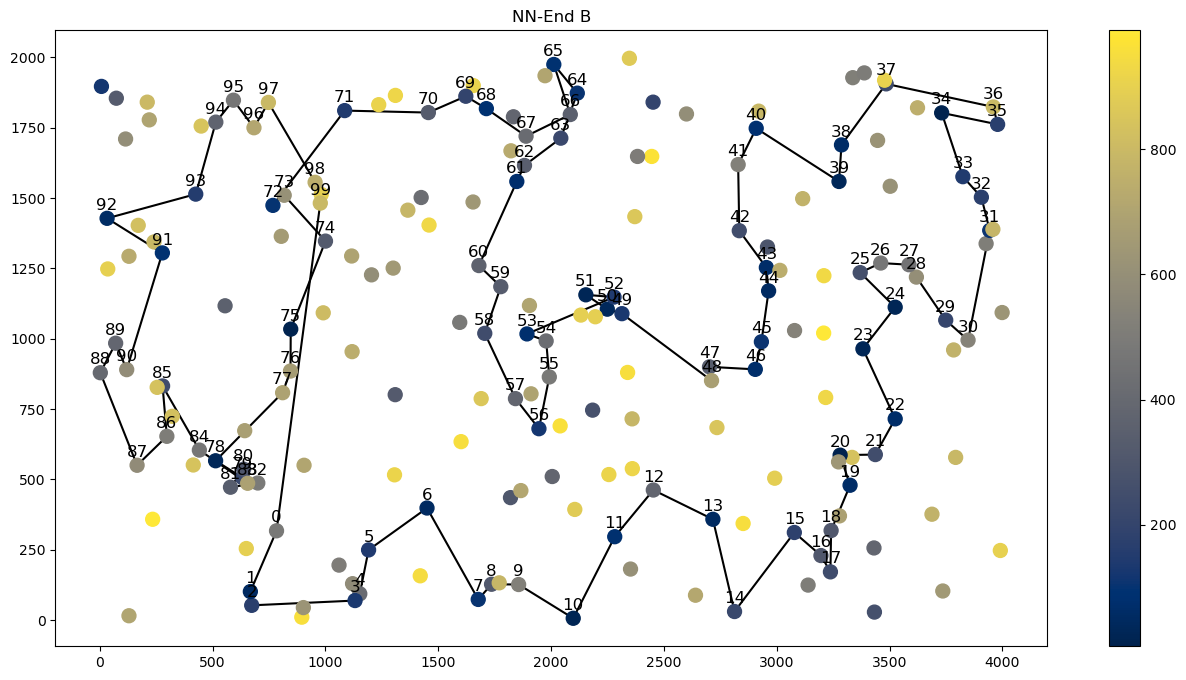

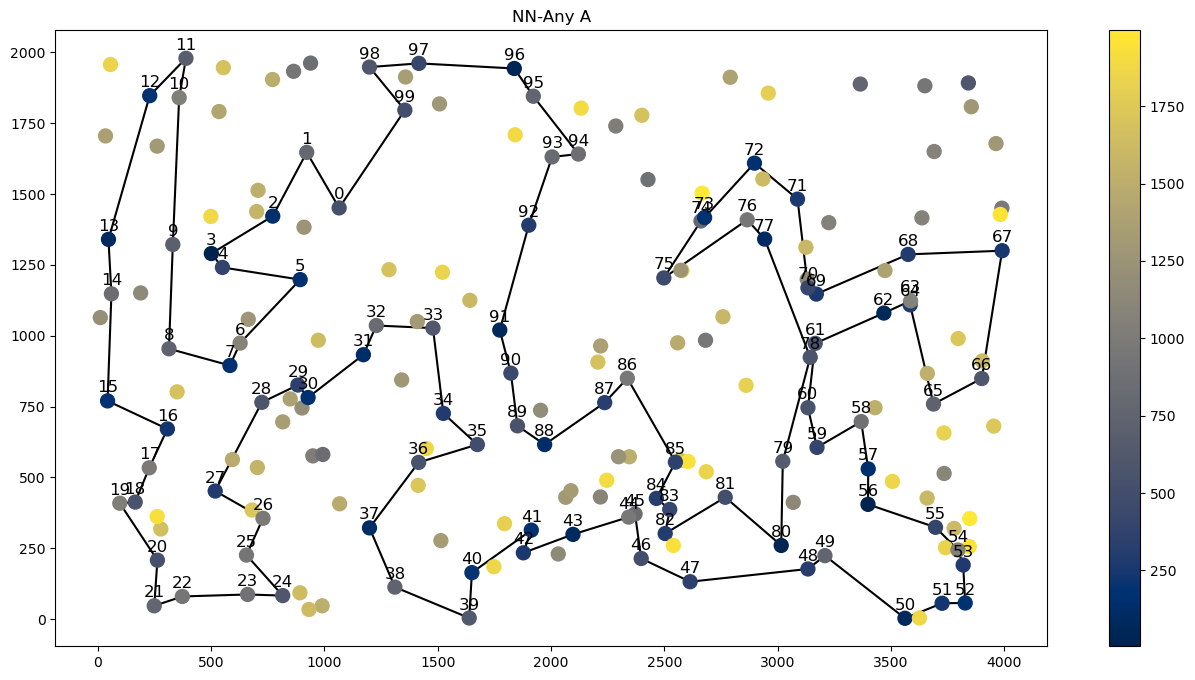

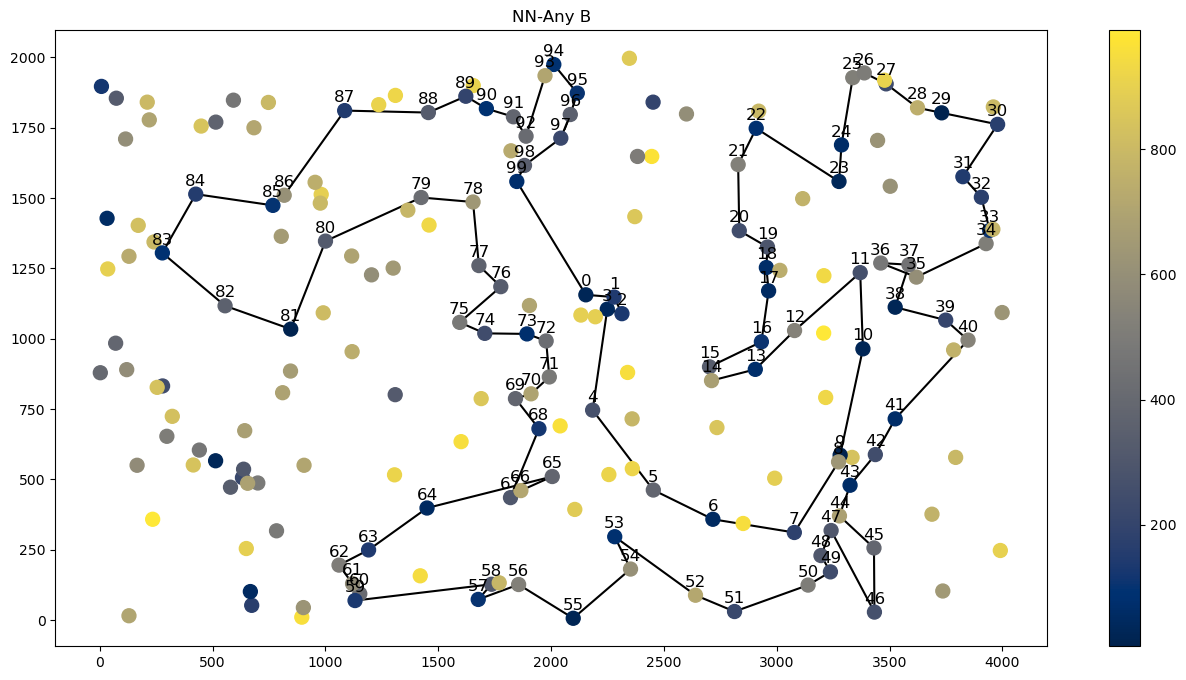

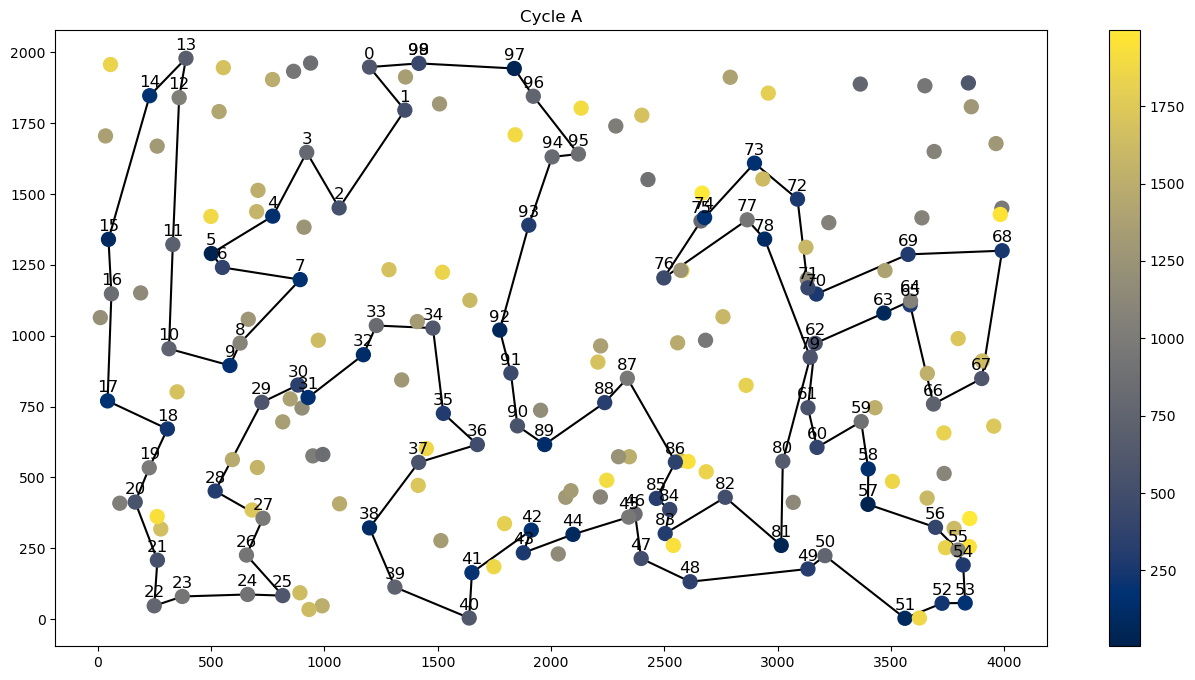

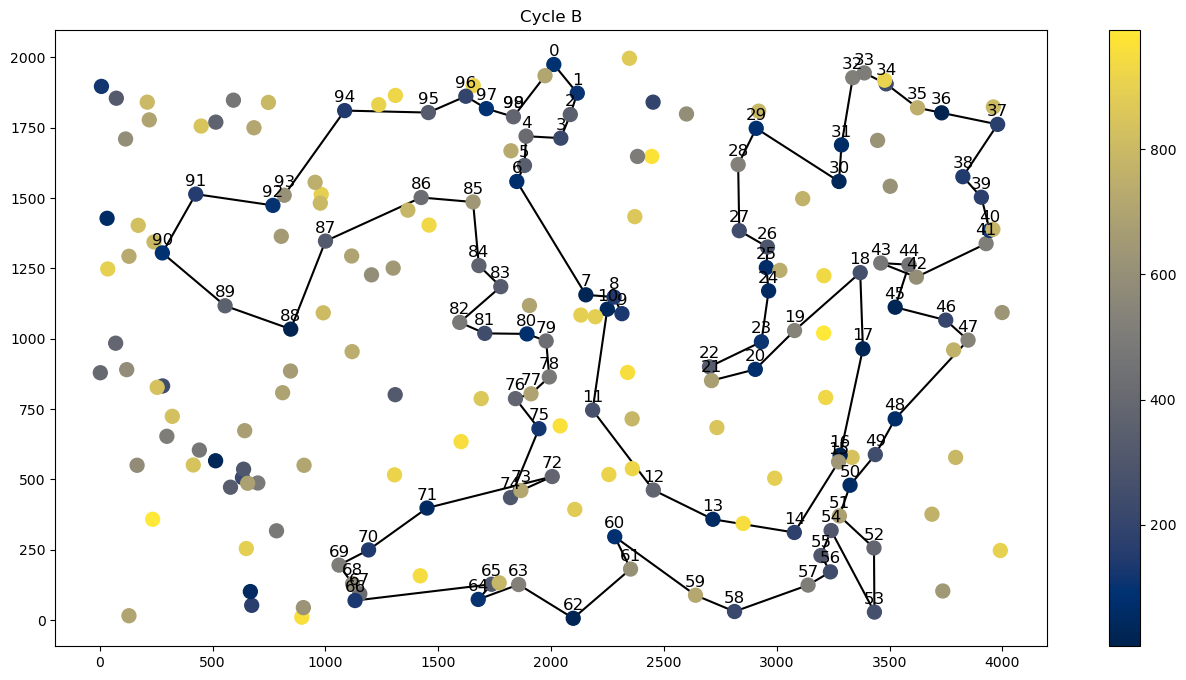

In [9]:
for index, ((_, _, _, solution), name) in enumerate(zip(experiments, columns)):
    if index % 2 == 0:
        tsp_a.plot(solution, name)
    else:
        tsp_b.plot(solution, name)

# Conclusions:
- Best method for instance A greedy cycle, but for an instance B was NN-end
- Random solution didn't have a luck even for such small sample of nodes and work much worse
- Average cost for an instance is almost two times higher for instance B, which can be an explanation, why the results of heuristics give us lower overall cost
- Average cost for an instance A and B was the lowest for NN-Any, but the highest was for NN-End also for both instances
- Maximum cost for an instance A and B was significantly higher for NN-End, but was quite similar for NN-Any and Greedy Cycle 